# nsopy: basic usage examples

Generally, the inputs required are

* a first-order oracle of the problem: for a given $x_k \in \mathbb{X} \subseteq \mathbb{R}^n$, it returns $f(x_k)$ and a valid subgradient $\nabla f(x_k)$,
* the projection function $\Pi_{\mathbb{X}}: \mathbb{R}^n \rightarrow \mathbb{R}^n$.

## Example 1: simple analytical example

Consider the following problem from [1, Sec. 2.1.3]:
$$
\begin{array}{ll}
 \min & f(x_1, x_2) = \left\{ \begin{array}{ll} 
             5(9x_1^2 + 16x_2^2)^{1/2} & \mathrm{if \ } x_1 > \left|x_2\right|, \\
             9x_1 + 16\left|x_2\right| & \mathrm{if \ } x_1 \leq \left|x_2\right| \\
 \end{array} \right.\\
 \mathrm{s.t.} & -3 \leq x_1, x_2 \leq 3.
\end{array}
$$
![alt text](img/ex_1.png)

This problem is interesting because a common gradient algorithm with backtracking initialized anywhere where in the set
$\left\{(x_1,x_2) \left| \ x_1 > \left|x_2\right| > (9/16)^2\left|x_1\right| \right. \right\}$
fails to converge to the optimum (-3,0), by remaining stuck at (0,0), even though it never touches any point where the function is nondifferentiable, see discussion in [1, Sec. 2.1.3]. Here we test our methods on this problem.

We write the oracle and projection as

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

%cd ..

C:\Users\vujanicr\PycharmProjects\nsopy


**Important Note**: all methods have been devised to solve the maximization of concave functions. To minimize (as in this case), we just need to negate the oracle's returns, i.e., the objective value $f(x_k)$ and the subgradient $\nabla f(x_k)$.

In [3]:
def oracle(x):
    assert -3 <= x[0] <= 3, 'oracle must be queried within X'
    assert -3 <= x[1] <= 3, 'oracle must be queried within X'
    # compute function value a subgradient
    if x[0] > abs(x[1]):
        f_x = 5*(9*x[0]**2 + 16*x[1]**2)**(float(1)/float(2))
        diff_f_x = np.array([float(9*5*x[0])/np.sqrt(9*x[0]**2 + 16*x[1]**2), 
                             float(16*5*x[0])/np.sqrt(9*x[0]**2 + 16*x[1]**2)])
    else:
        f_x = 9*x[0] + 16*abs(x[1])
        if x[1] >= 0:
            diff_f_x = np.array([9, 16], dtype=float)
        else:
            diff_f_x = np.array([9, -16], dtype=float)
    return 0, -f_x, -diff_f_x  # return negation to minimize


def projection_function(x):
    # projection on the box is simply saturating the entries
    return np.array([min(max(x[0],-3),3), min(max(x[1],-3),3)])

We can now solve it by applying one of the several methods available:

**Note**: try to change the method and see for yourself how their trajectories differ!

In [4]:
from methods.quasi_monotone_subgradient_methods import SGMDoubleSimpleAveraging as DSA
from methods.quasi_monotone_subgradient_methods import SGMTripleAveraging as TA
from methods.subgradient_methods import SubgradientMethod as SG
from methods.universal_gradient_methods import UniversalPGM as UPGM
from methods.universal_gradient_methods import UniversalDGM as UDGM
from methods.universal_gradient_methods import UniversalFGM as UFGM
from methods.method_loggers import GenericDualMethodLogger

In [13]:
# method = DSA(oracle, projection_function, n_constr=2, gamma=0.5)
# method = TA(oracle, projection_function, n_constr=2, variant=2, gamma=0.5)
# method = SG(oracle, projection_function, n_constr=2)
# method = UPGM(oracle, projection_function, n_constr=2, epsilon=10)
# method = UDGM(oracle, projection_function, n_constr=2, epsilon=1.0)
method = UFGM(oracle, projection_function, n_constr=2, epsilon=1.0)

method_logger = GenericDualMethodLogger(method)
# start from an different initial point
x_0 = np.array([2.01,2.01])
method.lambda_k = x_0

for iteration in range(500):
    method.dual_step()

And finally plot the result:

<IPython.core.display.Javascript object>


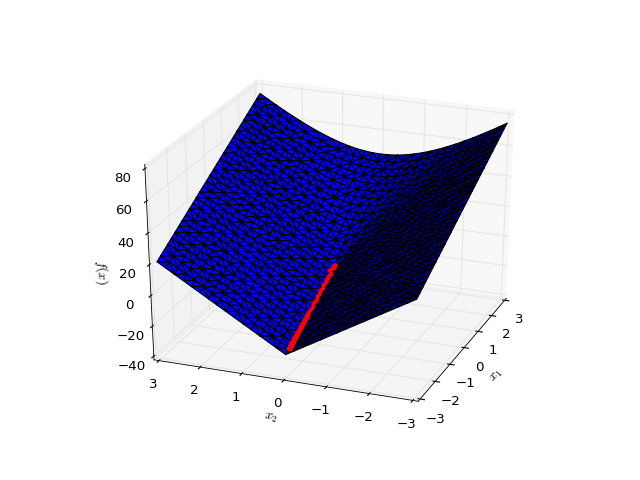

In [14]:
box = np.linspace(-3, 3, 31)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(np.array([x_1 for x_1 in box for x_2 in box]),
                np.array([x_2 for x_1 in box for x_2 in box]),
                np.array([-oracle([x_1, x_2])[1] for x_1 in box for x_2 in box]))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x)$')

plt.plot([x[0] for x in method_logger.lambda_k_iterates],
         [x[1] for x in method_logger.lambda_k_iterates],
         [-f_x for f_x in method_logger.d_k_iterates], 'r.-')

### References
[1] Dimitri Bertsekas, Convex Optimization Algorithms, Athena Scientific Belmont, 2015.